# Lecture 21

# 1) Minimum vertex cover problem

In [1]:
# To run this on your local machine you will have to install matplotlib to your ocean environment
# networkx is a package to work with graphs
#
import networkx as nx
%matplotlib inline

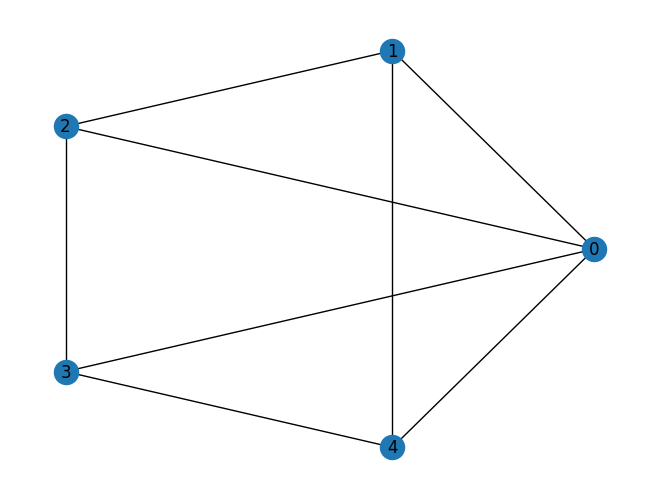

In [2]:
# Define a "wheel graph" with 5 nodes:
w5 = nx.wheel_graph(5)
nx.draw_circular(w5, with_labels=True)

In [3]:
# Let's solve the minimum exact cover using your local CPU, using the brute force method exact solver
#(evaluates all possibilities)
from dimod.reference.samplers import ExactSolver
sampler_CPU = ExactSolver()

In [4]:
# Use Ocean’s dwave_networkx to produce a BQM (binary quadratic model) 
# for our graph and solve the min vertex cover in on the selected sampler. 
# In other examples the BQM is explicitly created but the Ocean tool used here abstracts the BQM: 
# given the problem graph it returns a solution to a BQM it creates internally.
import dwave_networkx as dnx
print(dnx.min_vertex_cover(w5, sampler_CPU))

[0, 1, 3]


In [5]:
# Solve on the QPU. First define the QPU. Note how we can incorporate EmbeddingComposite to the definition:
from dwave.system import DWaveSampler, EmbeddingComposite
sampler_6 = EmbeddingComposite(DWaveSampler(id='Advantage_system6.4'))

In [7]:
solution = dnx.min_vertex_cover(w5, sampler_6)
print(solution)

[0, 1, 3]


Notice that this is the other correct solution!

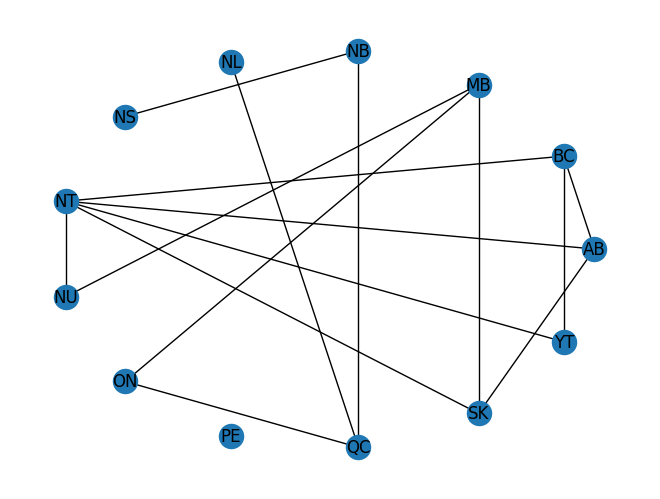

In [8]:
# Let's define a more complicated graph, provinces of Canada
provinces = ['AB', 'BC', 'MB', 'NB', 'NL', 'NS', 'NT', 'NU', 'ON', 'PE', 'QC', 'SK', 'YT']
neighbors = [('AB', 'BC'), ('AB', 'NT'), ('AB', 'SK'), ('BC', 'NT'), ('BC', 'YT'), ('MB', 'NU'),
             ('MB', 'ON'), ('MB', 'SK'), ('NB', 'NS'), ('NB', 'QC'), ('NL', 'QC'), ('NT', 'NU'),
             ('NT', 'SK'), ('NT', 'YT'), ('ON', 'QC')]
#
Canada = nx.Graph()
Canada.add_nodes_from(provinces)
Canada.add_edges_from(neighbors)
nx.draw_circular(Canada, with_labels=True)

In [9]:
# Use QPU to find min vertex cover for Canada
solution = dnx.min_vertex_cover(Canada, sampler_6)
print(solution)

['AB', 'MB', 'NS', 'NT', 'QC', 'YT']


In [ ]:
# Is this right ? :-)

# 2) Map coloring problem

In [10]:
import matplotlib.pyplot as plt    
from dimod.generators import combinations
from dimod import BinaryQuadraticModel
import dwave.inspector

## Set up the problem

Set up colors: The strings chosen here are recognized by the Matplotlib 
graphics library, which is used for plotting a solution in the last step, 
to represent colors yellow, green, red, and blue respectively.


In [11]:
colors = ['y', 'g', 'r', 'b']

Consider two binary variables $a$ and $b$. The BQM that models a "one-hot constraint" on these two variables looks like this:
$$ E=1-(a-b)^{2}= 1+2ab -a-b.$$

You can easily verify that the ground states (solutions with lowest values, zero in this case) are for variable assignments where just one of the variables has the value 1. Ocean has a convenient function to implement "one-hot constraints":

In [12]:
bqm_one_hot = combinations(['a', 'b'], 1)
print(bqm_one_hot)

BinaryQuadraticModel({'a': -1.0, 'b': -1.0}, {('b', 'a'): 2.0}, 1.0, 'BINARY')


Let's check using the exact solver that this BQM works:

In [13]:
print(ExactSolver().sample(bqm_one_hot))

   a  b energy num_oc.
1  1  0    0.0       1
3  0  1    0.0       1
0  0  0    1.0       1
2  1  1    1.0       1
['BINARY', 4 rows, 4 samples, 2 variables]


Notice how the energy is minimum only when $(a,b)=0,1$ or $(a,b)=(1,0)$.

Set a one-hot constraint on the four binary variables representing the possible colors for each province:

In [14]:
bqm_one_color = BinaryQuadraticModel('BINARY')
for province in provinces:
    variables = [province + "_" + c for c in colors]
    bqm_one_color.update(combinations(variables, 1))

In [15]:
print([variable for variable in bqm_one_color.variables if provinces[0] in variable])
print(bqm_one_color.linear['AB_y'], bqm_one_color.quadratic['AB_y', 'AB_g'])

['AB_y', 'AB_g', 'AB_r', 'AB_b']
-1.0 2.0


We now want to impose the constraint that two nodes (provinces) with a shared edge (border) not both select the same color. To do this we implement the following BQM:
$$E= a b. $$
That way the ground state happens when $(a,b)=(0,0), (1,0), (0,1)$. Only $(a,b)=(1,1)$ is penalized. Here is how you create this BQM:

In [16]:
bqm_and_plus = BinaryQuadraticModel({}, {'ab': 1}, 0, 'BINARY')
print(ExactSolver().sample(bqm_and_plus))

   a  b energy num_oc.
0  0  0    0.0       1
1  1  0    0.0       1
3  0  1    0.0       1
2  1  1    1.0       1
['BINARY', 4 rows, 4 samples, 2 variables]


The code below sets quadratic coefficients to +1 for interactions between neighboring provinces’ variables representing the same color, for example AB_y and BC_y (yellow for Alberta and British Columbia).

In [17]:
bqm_neighbors  = BinaryQuadraticModel('BINARY')
for neighbor in neighbors:
    v, u = neighbor
    interactions = [(v + "_" + c, u + "_" + c) for c in colors]
    for interaction in interactions:
        bqm_neighbors.add_quadratic(interaction[0], interaction[1], 1)

In [18]:
print(interactions)

[('ON_y', 'QC_y'), ('ON_g', 'QC_g'), ('ON_r', 'QC_r'), ('ON_b', 'QC_b')]


The previous sections created BQMs that represent the two types of constraints. For some problems, such constraints are supplementary to an objective that needs to be minimized, but in this problem, any solution that meets the constraints is a good solution. The BQM that represents the map coloring problem is therefore a simple sum of the BQMs representing the constraints:

In [19]:
bqm = bqm_one_color + bqm_neighbors

In [20]:
# Solve in the DWave sampler
sampleset = sampler_6.sample(bqm, num_reads=1000, label='Map Coloring BQM')
best = sampleset.first

In [21]:
# Verify that the sampler found a feasible solution
if best.energy > 0:
    print("Failed to color map. Try sampling again.")
else:
    print("Suceeded to color map.")

Suceeded to color map.


In [22]:
# The function below plots the map as a graph with nodes set to the selected color for each province.
def plot_map(sample):
    G = nx.Graph()
    G.add_nodes_from(provinces)
    G.add_edges_from(neighbors)
    # Create a {province: selected color} dict
    color_map = {}
    for province in provinces:
        for c in colors:
            if sample[province + '_' + c]:
                color_map[province] = c
    # Plot with the selected colors
    node_colors = [color_map.get(node) for node in G.nodes()]
    nx.draw_circular(G, with_labels=True, node_color=node_colors, node_size=3000, cmap=plt.cm.rainbow)
    plt.show()

/home/user/.local/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


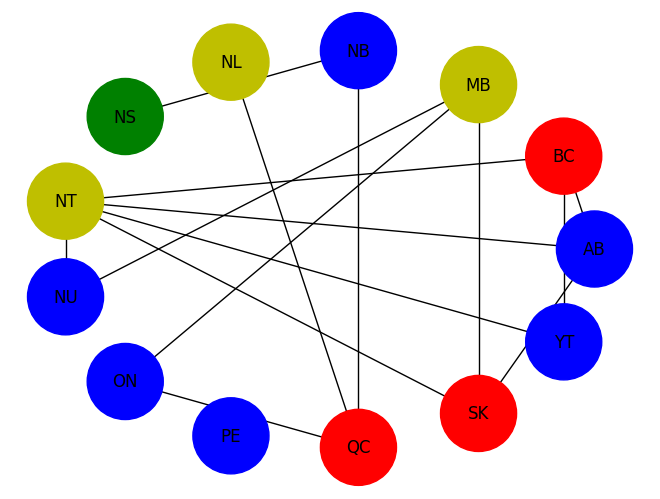

In [23]:
plot_map(best.sample)

# 3) Maximum cut with Ising representation

In [24]:
from collections import defaultdict

Set up our graph:

In [25]:
# Create empty graph
G = nx.Graph()

In [26]:
# Add edges to the graph (also adds nodes)
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])

Set up our dictionary for $h_i$ and $J_{ij}$:

In [27]:
# Initialize our h vector, J matrix
h = defaultdict(int)
J = defaultdict(int)

In [28]:
# Update J matrix for every edge in the graph
for i, j in G.edges:
    J[(i,j)]+= 1

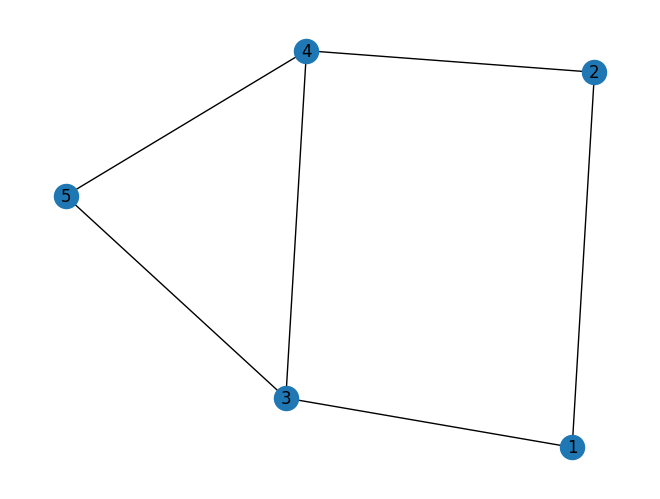

In [29]:
nx.draw(G,with_labels=True)

In [34]:
# ------- Run our QUBO on the QPU -------
# Set up QPU parameters
chainstrength = 2
numruns = 1000

In [35]:
response = sampler_6.sample_ising(h, J,chain_strength=chainstrength,num_reads=numruns,
                                     label='Example - Maximum Cut Ising')

In [36]:
# ------- Print results to user -------
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for sample, E in response.data(fields=['sample','energy']):
    S0 = [k for k,v in sample.items() if v == -1]
    S1 = [k for k,v in sample.items() if v == 1]
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int((6-E)/2))))

------------------------------------------------------------
          Set 0          Set 1    Energy        Cut Size    
------------------------------------------------------------
      [1, 4, 5]         [2, 3]     -4.0             5       
      [2, 3, 5]         [1, 4]     -4.0             5       
         [2, 3]      [1, 4, 5]     -4.0             5       
         [1, 4]      [2, 3, 5]     -4.0             5       
         [2, 5]      [1, 3, 4]     -2.0             4       
         [3, 4]      [1, 2, 5]     -2.0             4       


Cut Size is total number of edges minus energy all divided by 2:

$\text{Cut Size} = \frac{n_{edges} - E}{2}$